In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE,ADASYN
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.exceptions import FitFailedWarning
import warnings

In [62]:
# Read in the cleaned data
df = pd.read_csv('Customer-Churn-Records-clean.csv')

df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Card Type,Point Earned
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1,2,DIAMOND,464
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,1,3,DIAMOND,456
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1,3,DIAMOND,377
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0,5,GOLD,350
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0,5,GOLD,425


In [63]:
# Dropping Complain as it is highly, highly correlated with the target variable
df.drop('Complain', axis=1, inplace=True)

In [64]:
# Define categorical and numerical columns
cat_cols = ['Geography','Gender','Card Type','HasCrCard','IsActiveMember', 'NumOfProducts'] # 'Complain',
num_cols = ['CreditScore','Age','Tenure','Balance','EstimatedSalary',
            'Satisfaction Score','Point Earned']
# One hot encode categorical variables
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

### Train/test split supporting multiple splits for stepped optimization

In [65]:
# Create features and target
X = df.drop('Exited', axis=1)
y = df['Exited']

# Train/test split for baseline model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

# Further splitting the test data into test and holdout set
X_test, X_holdout, y_test, y_holdout = train_test_split(X_test, y_test, test_size=0.5, random_state=67, stratify=y_test)


### Baseline logistic regression model

In [66]:
# baseline logistic regression model - no resampling, no scaling,  no hyperparameter tuning
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Extract confusion matrix values
true_neg, false_pos, false_neg, true_pos = conf_matrix.ravel()

# Create a dictionary to store the scores
score_dict = {
    'Model': 'Baseline',
    'Accuracy Score': accuracy,
    'Balanced Accuracy Score': balanced_accuracy,
    'Precision Score': precision,
    'Recall Score': recall,
    'F1 Score': f1,
    'True Negative': true_neg,
    'False Positive': false_pos,
    'False Negative': false_neg,
    'True Positive': true_pos
}

# Create or append to the DataFrame
df_results = pd.DataFrame([score_dict])

# Print the DataFrame
df_results

,Model,Accuracy Score,Balanced Accuracy Score,Precision Score,Recall Score,F1 Score,True Negative,False Positive,False Negative,True Positive
0,Baseline,0.789,0.515654,0.37931,0.053922,0.094421,778,18,193,11


### Logistic regression model using class_weight method

In [67]:
# baseline logistic regression model - no resampling, no scaling,  no hyperparameter tuning
logreg = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)


# Extract confusion matrix values
true_neg, false_pos, false_neg, true_pos = conf_matrix.ravel()

# Create a dictionary to store the scores
score_dict = {
    'Model': 'class_weight = balanced',
    'Accuracy Score': accuracy,
    'Balanced Accuracy Score': balanced_accuracy,
    'Precision Score': precision,
    'Recall Score': recall,
    'F1 Score': f1,
    'True Negative': true_neg,
    'False Positive': false_pos,
    'False Negative': false_neg,
    'True Positive': true_pos
}

# Create or append to the DataFrame
df_results = pd.concat([df_results, pd.DataFrame(score_dict, index=[0])], ignore_index=True)

# Print the updated DataFrame
df_results

,Model,Accuracy Score,Balanced Accuracy Score,Precision Score,Recall Score,F1 Score,True Negative,False Positive,False Negative,True Positive
0,Baseline,0.789,0.515654,0.379310,0.053922,0.094421,778,18,193,11
1,class_weight = balanced,0.664,0.681397,0.343602,0.710784,0.463259,519,277,59,145


### Logistic regression model with ADASYN resampling
ADASYN resampling was chosing over SMOTE or other techniques as it most greatly improved holdout scores.

In [68]:
# Apply ADASYN resampling to the training data only
adasyn = ADASYN(random_state=42)
X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train, y_train)

# Now use X_train_resampled and y_train_resampled for training the model
X_train_resampled.shape, y_train_resampled.shape


# log reg with adasyn resampling
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train_resampled, y_train_resampled)
y_pred = logreg.predict(X_test)

# Calculate the scores
accuracy = accuracy_score(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Extract confusion matrix values
true_neg, false_pos, false_neg, true_pos = conf_matrix.ravel()

# Create a dictionary to store the scores
score_dict = {
    'Model': 'ADASYN Resampling',
    'Accuracy Score': accuracy,
    'Balanced Accuracy Score': balanced_accuracy,
    'Precision Score': precision,
    'Recall Score': recall,
    'F1 Score': f1,
    'True Negative': true_neg,
    'False Positive': false_pos,
    'False Negative': false_neg,
    'True Positive': true_pos
}

# Append the scores to the df_results DataFrame
df_results = pd.concat([df_results, pd.DataFrame(score_dict, index=[0])], ignore_index=True)


# Print the updated DataFrame
df_results

,Model,Accuracy Score,Balanced Accuracy Score,Precision Score,Recall Score,F1 Score,True Negative,False Positive,False Negative,True Positive
0,Baseline,0.789,0.515654,0.379310,0.053922,0.094421,778,18,193,11
1,class_weight = balanced,0.664,0.681397,0.343602,0.710784,0.463259,519,277,59,145
2,ADASYN Resampling,0.670,0.688812,0.350000,0.720588,0.471154,523,273,57,147


### Logistic regression model with ADASYN resampling and StandardScaler

In [69]:
# Scaling the numerical features, including my holdout set

# Separate the numerical and categorical data
X_train_num = X_train_resampled[num_cols]
X_train_cat = X_train_resampled.drop(num_cols, axis=1)
X_test_num = X_test[num_cols]
X_test_cat = X_test.drop(num_cols, axis=1)
X_holdout_num = X_holdout[num_cols]  # Separate numerical features from X_holdout
X_holdout_cat = X_holdout.drop(num_cols, axis=1)  # Separate categorical features from X_holdout

# Create a scaler and fit_transform on training numerical data, then transform test numerical data
scaler = StandardScaler()
X_train_num_scaled = scaler.fit_transform(X_train_num)
X_test_num_scaled = scaler.transform(X_test_num)
X_holdout_num_scaled = scaler.transform(X_holdout_num)  # Scale numerical features in X_holdout at the same time

# Convert these arrays back into DataFrames
X_train_num_scaled = pd.DataFrame(X_train_num_scaled, columns=num_cols).reset_index(drop=True)
X_test_num_scaled = pd.DataFrame(X_test_num_scaled, columns=num_cols).reset_index(drop=True)
X_holdout_num_scaled = pd.DataFrame(X_holdout_num_scaled, columns=num_cols).reset_index(drop=True)  # Convert scaled X_holdout to DataFrame

# Concatenate the numerical and categorical dataframes to create a complete feature set
X_train_scaled = pd.concat([X_train_num_scaled, X_train_cat.reset_index(drop=True)], axis=1)
X_test_scaled = pd.concat([X_test_num_scaled, X_test_cat.reset_index(drop=True)], axis=1)
X_holdout_scaled = pd.concat([X_holdout_num_scaled, X_holdout_cat.reset_index(drop=True)], axis=1)  # Concatenate scaled numerical and categorical dataframes for X_holdout


In [70]:
# Create and train the model with resampled and scaled training data
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train_scaled, y_train_resampled)
y_pred = logreg.predict(X_test_scaled)

# Calculate the scores
accuracy = accuracy_score(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Extract confusion matrix values
true_neg, false_pos, false_neg, true_pos = conf_matrix.ravel()

# Create a dictionary to store the scores
score_dict = {
    'Model': 'Scaled and ADASYN',
    'Accuracy Score': accuracy,
    'Balanced Accuracy Score': balanced_accuracy,
    'Precision Score': precision,
    'Recall Score': recall,
    'F1 Score': f1,
    'True Negative': true_neg,
    'False Positive': false_pos,
    'False Negative': false_neg,
    'True Positive': true_pos
}

# Append the scores to the df_results DataFrame
df_results = pd.concat([df_results, pd.DataFrame(score_dict, index=[0])], ignore_index=True)

# show the results
df_results

,Model,Accuracy Score,Balanced Accuracy Score,Precision Score,Recall Score,F1 Score,True Negative,False Positive,False Negative,True Positive
0,Baseline,0.789,0.515654,0.379310,0.053922,0.094421,778,18,193,11
1,class_weight = balanced,0.664,0.681397,0.343602,0.710784,0.463259,519,277,59,145
2,ADASYN Resampling,0.670,0.688812,0.350000,0.720588,0.471154,523,273,57,147
3,Scaled and ADASYN,0.769,0.694490,0.447876,0.568627,0.501080,653,143,88,116


### Hypertuning the logistic regression model with the scaled and sampled data
As we are using a logistic regression model and the parameters space is not that large, I have choosen a grid search for the best results. 

In [71]:
# Create a parameter grid
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear'], #'lbfgs', saga
    'max_iter': [1000, 1500, 2000, 2500],
    'class_weight': ['balanced', None],
    'random_state': [42, 93, 231]
}

# Create a grid search object
grid_logreg = GridSearchCV(estimator=logreg, param_grid=param_grid, scoring='accuracy', cv=3, verbose=0, n_jobs=-1)

# # Customized grid search
# for penalty in param_grid['penalty']:
#     for solver in param_grid['solver']:
#         if (penalty == 'l1' and solver == 'lbfgs') or (penalty is None):
#             continue  # Skip incompatible combinations
#         else:
#             grid_logreg.estimator.set_params(penalty=penalty, solver=solver)
#             try:
#                 with warnings.catch_warnings():
#                     warnings.filterwarnings("error", category=FitFailedWarning)
#                     grid_logreg.fit(X_train_scaled, y_train_resampled)
#             except FitFailedWarning:
#                 continue

# Fit the model
grid_logreg.fit(X_train_scaled, y_train_resampled)

# Get the best parameters
best_params = grid_logreg.best_params_
print(f"The best parameters are: {best_params}")

# Make predictions on the holdout set
y_pred = grid_logreg.predict(X_holdout_scaled)

# Calculate the scores for the holdout set
accuracy = accuracy_score(y_holdout, y_pred)
balanced_accuracy = balanced_accuracy_score(y_holdout, y_pred)
precision = precision_score(y_holdout, y_pred)
recall = recall_score(y_holdout, y_pred)
f1 = f1_score(y_holdout, y_pred)
conf_matrix = confusion_matrix(y_holdout, y_pred)

# Extract confusion matrix values
true_neg, false_pos, false_neg, true_pos = conf_matrix.ravel()

# Create a dictionary to store the scores
score_dict = {
    'Model': 'Tuned, scaled and ADASYN (holdout)',
    'Accuracy Score': accuracy,
    'Balanced Accuracy Score': balanced_accuracy,
    'Precision Score': precision,
    'Recall Score': recall,
    'F1 Score': f1,
    'True Negative': true_neg,
    'False Positive': false_pos,
    'False Negative': false_neg,
    'True Positive': true_pos
}

# Add the scores to the df_results DataFrame
df_results = pd.concat([df_results, pd.DataFrame(score_dict, index=[0])], ignore_index=True)

# Show the results
df_results


The best parameters are: {'C': 100, 'class_weight': 'balanced', 'max_iter': 1000, 'penalty': 'l1', 'random_state': 93, 'solver': 'liblinear'}


,Model,Accuracy Score,Balanced Accuracy Score,Precision Score,Recall Score,F1 Score,True Negative,False Positive,False Negative,True Positive
0,Baseline,0.789,0.515654,0.379310,0.053922,0.094421,778,18,193,11
1,class_weight = balanced,0.664,0.681397,0.343602,0.710784,0.463259,519,277,59,145
2,ADASYN Resampling,0.670,0.688812,0.350000,0.720588,0.471154,523,273,57,147
3,Scaled and ADASYN,0.769,0.694490,0.447876,0.568627,0.501080,653,143,88,116
4,"Tuned, scaled and ADASYN (holdout)",0.809,0.756072,0.525097,0.666667,0.587473,673,123,68,136


## Feature importance of the scaled, resampled and tuned final model

In [72]:
# Feature importances
importance = logreg.coef_[0]
feature_importance = pd.DataFrame({'Feature': X_train_scaled.columns, 'Importance': importance})
feature_importance.sort_values(by='Importance', ascending=False, inplace=True)

print(feature_importance)

               Feature  Importance
17     NumOfProducts_4    2.927053
16     NumOfProducts_3    1.959365
1                  Age    0.803964
7    Geography_Germany    0.423138
4      EstimatedSalary    0.026478
6         Point Earned   -0.060758
3              Balance   -0.070580
0          CreditScore   -0.082107
2               Tenure   -0.109876
5   Satisfaction Score   -0.180099
13         HasCrCard_1   -0.600086
8      Geography_Spain   -0.787237
9          Gender_Male   -1.082258
12    Card Type_SILVER   -1.377691
11  Card Type_PLATINUM   -1.530682
10      Card Type_GOLD   -1.540990
14    IsActiveMember_1   -1.548947
15     NumOfProducts_2   -2.385092


Text(0.5, 1.0, 'Feature Importance of Logistic Regression Model - Bank Churn Data (tuned,scaled and resampled)')

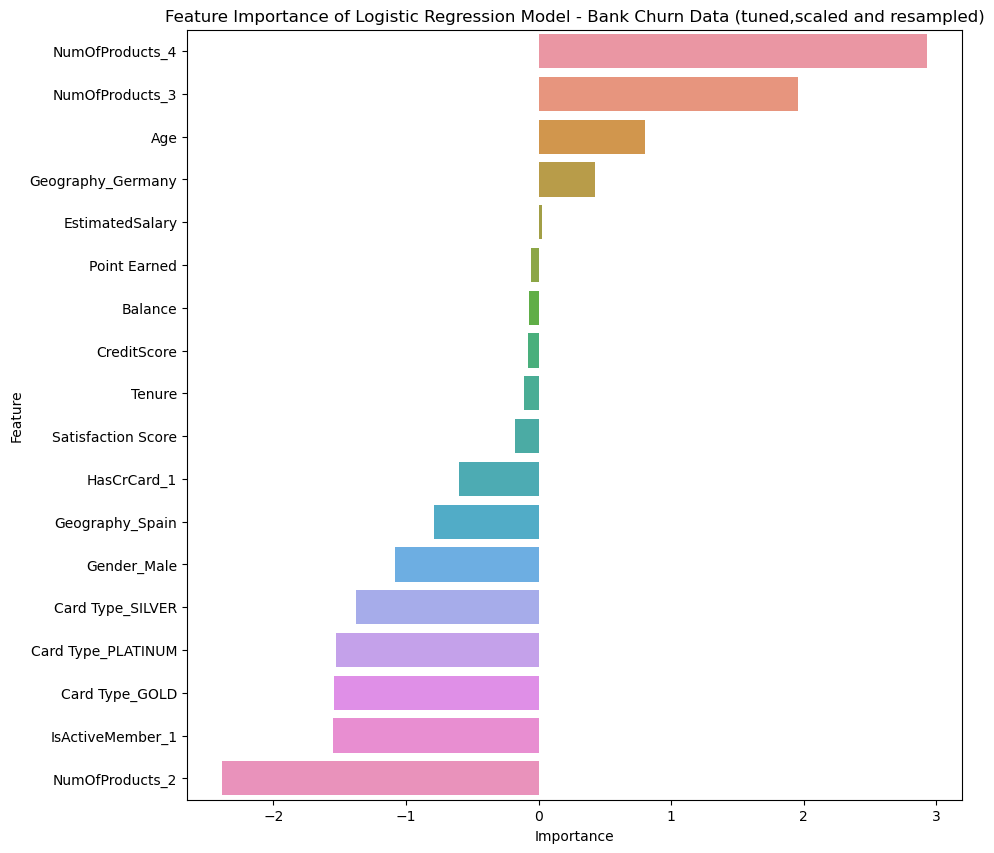

In [73]:
# Bar plot of feature importances

"""A positive value suggests that the corresponding feature pushes the prediction more towards the positive class, 
while a negative value suggests it pushes the prediction more towards the negative class"""

plt.figure(figsize=(10, 10))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance of Logistic Regression Model - Bank Churn Data (tuned,scaled and resampled)')